In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

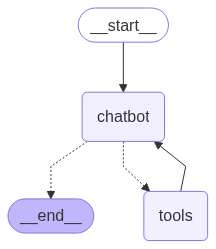

In [2]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import display, Image
from langchain_teddynote.tools import GoogleNews

# 1. 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]
    dummy_data : Annotated[str, "dummy"]

# 2. 도구 정의
news_tool = GoogleNews()

@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)

tools = [search_keyword]

llm = ChatOpenAI(model="gpt-5-nano")
llm_with_tools = llm.bind_tools(tools)

# 3. 노드 정의
def chatbot(state : State):
    return {
        "messages": [llm_with_tools.invoke(state['messages'])],
        "dummy_data": "[chatbot] 호출, dummy data"
    }

# 상태 그래프 생성 + 노드 추가
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
tool_node = ToolNode(tools=tools)

graph_builder.add_node("tools", tool_node)

# 4. 엣지로 노드 연결
# 조건부 엣지
graph_builder.add_conditional_edges("chatbot", tools_condition)

graph_builder.add_edge("tools", "chatbot")      # tools -> chatbot
graph_builder.add_edge(START, "chatbot")        # START -> chatbot
graph_builder.add_edge("chatbot", END)

# 5. 그래프 컴파일
graph = graph_builder.compile()

# 컴파일한 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [3]:
# 랭그래프 각 노드를 스트리밍 출력
from langchain_core.runnables import RunnableConfig

# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 상태를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-tag"],  # Tag
)

In [4]:
for event in graph.stream(input=input, config=config):
    for key, value in event.items():
        print(f"\n[ {key} ]\n")
        # value 에 messages 가 존재하는 경우
        if "messages" in value:
            messages = value["messages"]
            # 가장 최근 메시지 1개만 출력합니다.
            value["messages"][-1].pretty_print()


[ chatbot ]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_36qUBV1YZN1Q67pAiNjUkgyr)
 Call ID: call_36qUBV1YZN1Q67pAiNjUkgyr
  Args:
    query: 2024년 노벨 문학상

[ tools ]

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiTkFVX3lxTE1WR2QxeXktVFlQVWE2NUgwVjM4SWJfX0JZVk1Tdm5abWxfQk5NV1FxVmQybnIycF91SmdzNHlaQTBsWEczQ1FuUWFIZUJJdw?oc=5", "content": "[1만호 100대 사건]〈96〉한강, 한국인 최초 노벨문학상 수상 - 전자신문"}, {"url": "https://news.google.com/rss/articles/CBMioAFBVV95cUxNSC1MaVZoMmVGZWktR1NaMDV0OFhLUUxZTXY5TEJyWGdvRnp4WG5JYk9OZkxuMGJXZDQ1cnlwZXBiV0hXX3AtUUhRN1IzeVdZZi1BYjhGbFI1Zk1pOXUzX1llRzRGZmJHbXRKM0RBM2RfSnBoVTA0aTlKSlpPVGJ4N0R5cmg5VDNyOEdMRjFfUkhwUVBLOFBqVGtyeHREZTRw?oc=5", "content": "아시아 여성 최초 노벨문학상 수상🏅 전세계가 주목한 작가 한강은 누구? - www .oiv .int."}, {"url": "https://news.google.com/rss/articles/CBMibEFVX3lxTE9saEhrVVp3RWFCR1B4SWlDVGhtQ

GraphRecursionError: Recursion limit of 10 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT